In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import joblib
from sklearn.preprocessing import LabelEncoder
# Create models folder
if not os.path.exists('models'):
    os.makedirs('models')

%matplotlib inline
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

# ---Data Loading & Initial Inspection---

In [14]:
df = pd.read_csv("data/german_credit_data.csv")
print("Data Shape:", df.shape)
display(df.head())
display(df.describe(include="all").T)
print("Risk Counts:\n", df["Risk"].value_counts())

Data Shape: (1000, 11)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,NaN,NaN,NaN,499.5,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,817,4,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,606,3,little,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Risk Counts:
 Risk
good    700
bad     300
Name: count, dtype: int64


In [15]:
# Handling Skewness in Credit Amount as identified in EDA
df['Credit amount_log'] = np.log(df['Credit amount'])

In [16]:
# Engineering: Monthly burden
df['Monthly_Installment'] = df['Credit amount'] / df['Duration']

In [17]:
# Imputing Missing Categorical Data
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    
display(df.head())

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Credit amount_log,Monthly_Installment
0,0,67,male,2,own,little,little,1169,6,radio/TV,good,7.063904,194.833333
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,8.691315,123.979167
2,2,49,male,1,own,little,little,2096,12,education,good,7.647786,174.666667
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good,8.972337,187.666667
4,4,53,male,2,free,little,little,4870,24,car,bad,8.490849,202.916667


# Statistical Groupings (The Risk Check)

In [18]:
# Detailed check of how Risk correlates with loan size and length
risk_analysis = df.groupby("Risk").agg({
    'Age': 'mean',
    'Credit amount': 'mean',
    'Duration': 'mean',
    'Monthly_Installment': 'mean'
})
display(risk_analysis)

,Age,Credit amount,Duration,Monthly_Installment
Risk,,,,
bad,33.963333,3938.126667,24.860000,172.044031
good,36.224286,2985.457143,19.207143,165.819730


# ---Statistical Groupings (The Risk Check)----

In [19]:
# Numerical averages by Risk
display(df.groupby("Risk")[["Age", "Credit amount", "Duration"]].mean())

# Pivot Table: Purpose vs Housing
pivot = pd.pivot_table(df, values="Credit amount", index="Housing", columns="Purpose")
display(pivot)

,Age,Credit amount,Duration
Risk,,,
bad,33.963333,3938.126667,24.860000
good,36.224286,2985.457143,19.207143


Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
Housing,,,,,,,,
free,4931.800000,5834.181818,NaN,4387.266667,4100.181818,2417.333333,2750.666667,7227.250
own,3800.592105,3329.949772,1546.5,2198.647059,3107.459016,2540.493392,2866.000000,8700.375
rent,5614.125000,3487.968254,1255.5,2931.000000,2727.354167,2199.763158,1522.000000,NaN


In [20]:
# Identify Categorical vs Numerical early
cat_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
num_features = ['Age', 'Job', 'Credit amount', 'Duration']

# Visual EDA - Distributions & Outliers

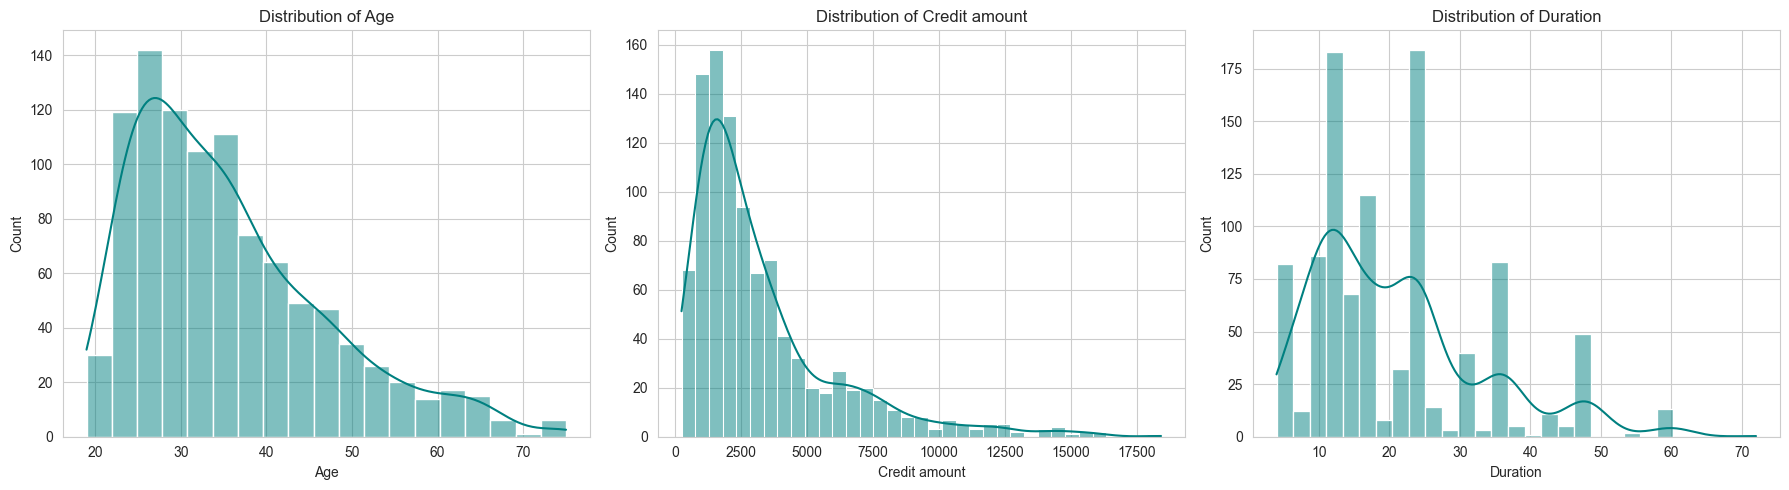

C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2821832398.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2821832398.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2821832398.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")


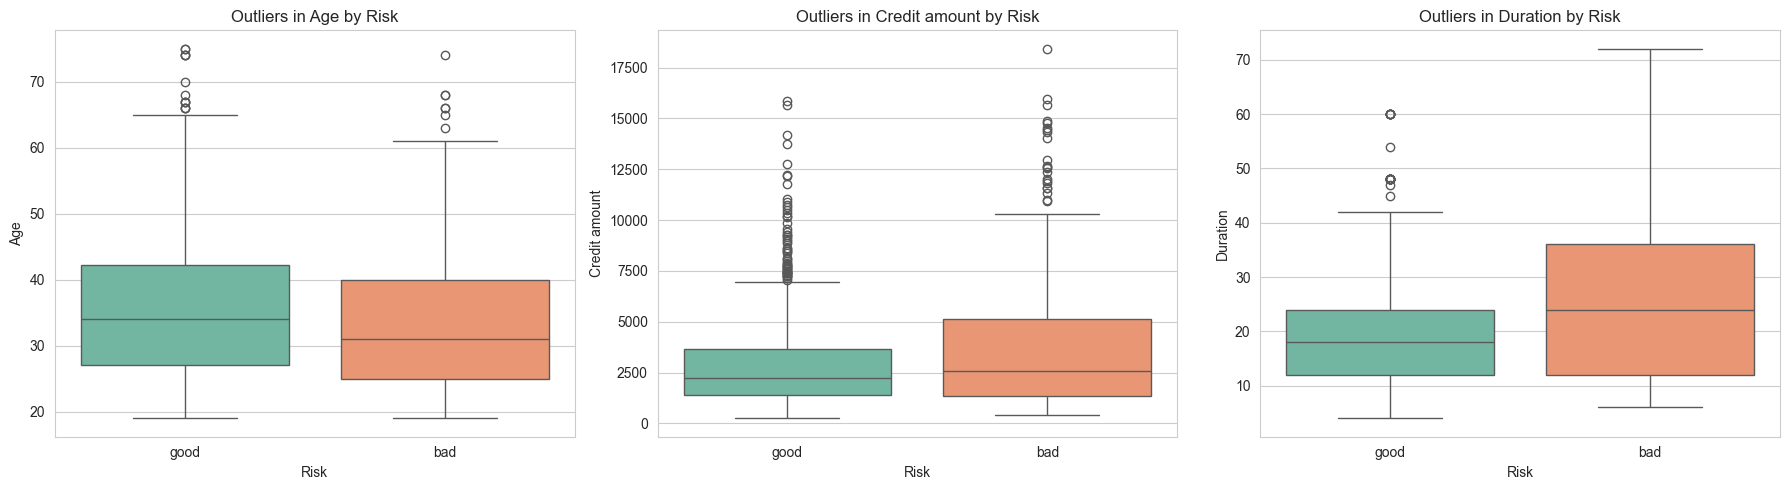

In [21]:
# 1. Histograms for Numerical Features (Checking Distribution)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
num_cols = ["Age", "Credit amount", "Duration"]

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="teal")
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# 2. Boxplots for Detecting Outliers
plt.figure(figsize=(18, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col], x=df["Risk"], palette="Set2")
    plt.title(f"Outliers in {col} by Risk")

plt.tight_layout()
plt.show()

# Visual EDA (Distributions & Multivariate Analysis)

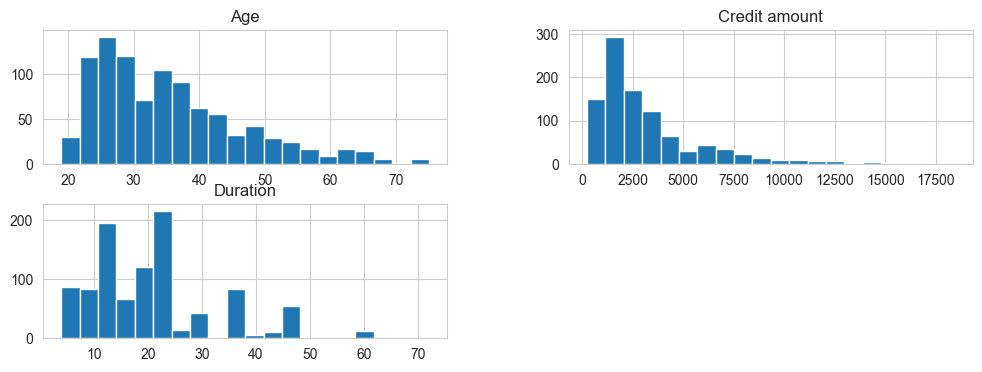

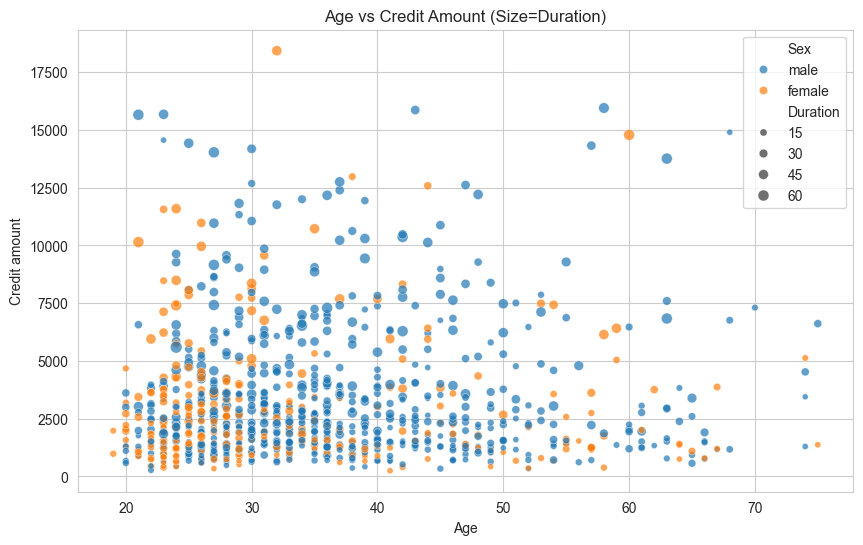

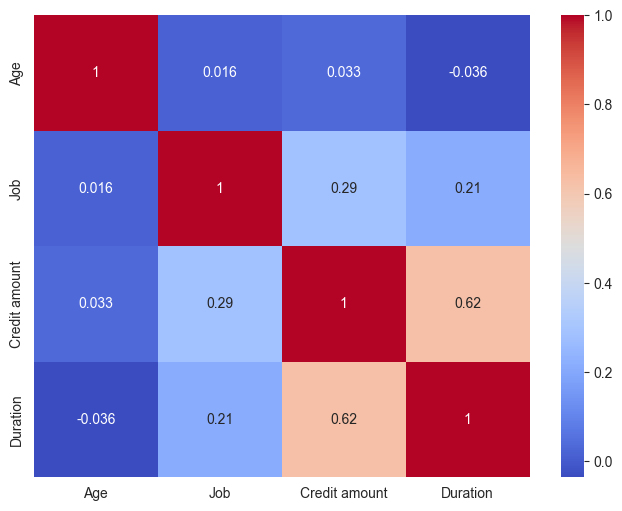

In [22]:
# Distributions
df[["Age", "Credit amount", "Duration"]].hist(bins=20, figsize=(12, 4))
plt.show()

# The "Check" Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Age", y="Credit amount", hue="Sex", size="Duration", alpha=0.7)
plt.title("Age vs Credit Amount (Size=Duration)")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[["Age", "Job", "Credit amount", "Duration"]].corr(), annot=True, cmap="coolwarm")
plt.show()

# Advanced Business Insights."

# Distribution by Risk (The Target Variable) 
It's important to see if your dataset is "imbalanced." In credit risk, we usually have more "Good" than "Bad" examples.

# Feature Engineering


C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2249006356.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk', data=df, palette='viridis')


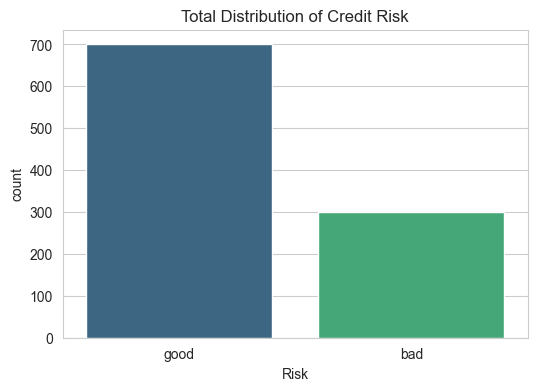

Risk
good    70.0
bad     30.0
Name: proportion, dtype: float64


In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk', data=df, palette='viridis')
plt.title('Total Distribution of Credit Risk')
plt.show()

# Percentage breakdown
print(df['Risk'].value_counts(normalize=True) * 100)

# Risk Distribution by Category (Cross-Tabulation)

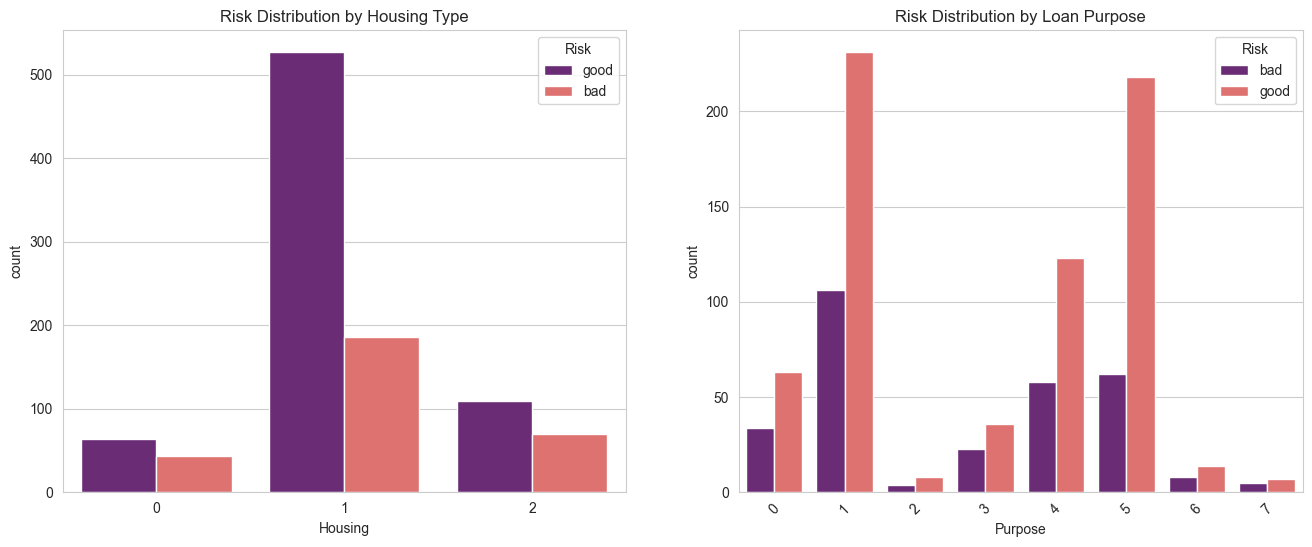

In [26]:
# Create a subplot for Housing and Purpose
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Risk by Housing
sns.countplot(x='Housing', hue='Risk', data=df, ax=axes[0], palette='magma')
axes[0].set_title('Risk Distribution by Housing Type')

# Risk by Purpose
sns.countplot(x='Purpose', hue='Risk', data=df, ax=axes[1], palette='magma')
axes[1].set_title('Risk Distribution by Loan Purpose')
plt.xticks(rotation=45)

plt.show()

# Age Distribution by Risk (KDE Plot)

C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2854968921.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Risk'] == 'good']['Age'], label='Good Risk', shade=True, color="blue")
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2854968921.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Risk'] == 'bad']['Age'], label='Bad Risk', shade=True, color="red")


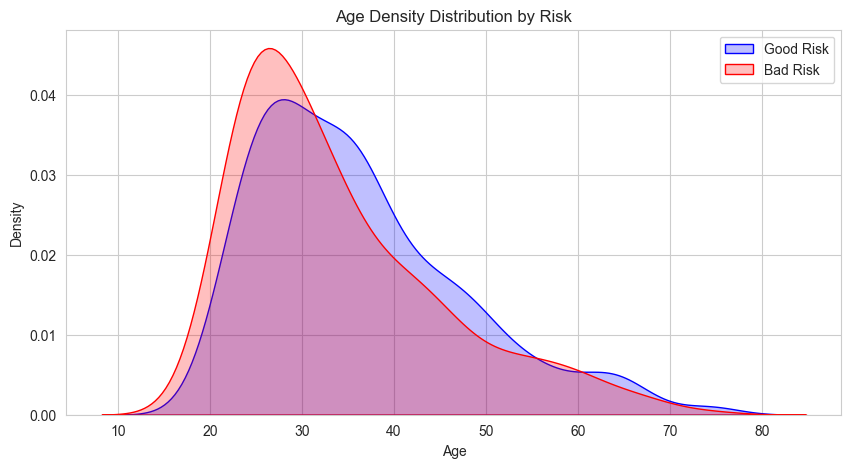

In [27]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['Risk'] == 'good']['Age'], label='Good Risk', shade=True, color="blue")
sns.kdeplot(df[df['Risk'] == 'bad']['Age'], label='Bad Risk', shade=True, color="red")
plt.title('Age Density Distribution by Risk')
plt.xlabel('Age')
plt.legend()
plt.show()

# Wealth Analysis (Saving & Checking Accounts)

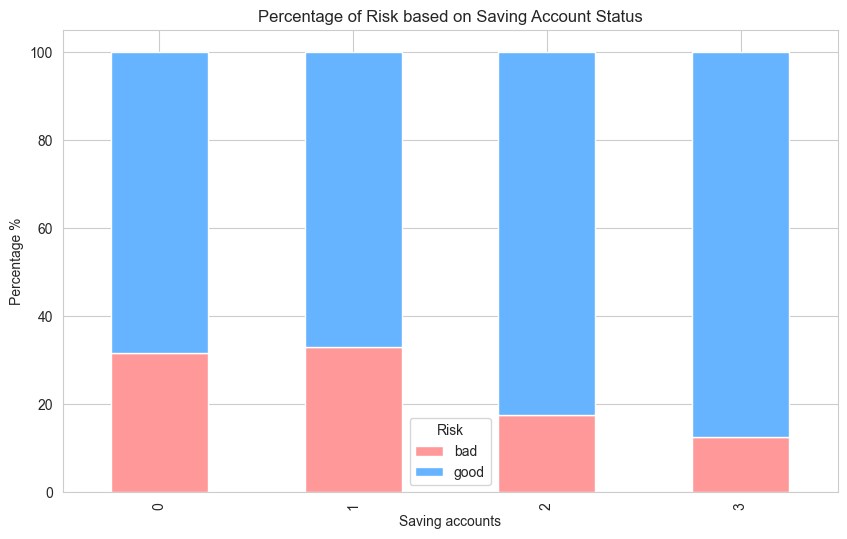

In [28]:
# Grouping by Saving accounts and Risk
wealth_risk = pd.crosstab(df['Saving accounts'], df['Risk'], normalize='index') * 100
wealth_risk.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999','#66b3ff'])
plt.title('Percentage of Risk based on Saving Account Status')
plt.ylabel('Percentage %')
plt.show()

# Countplot Distribution Subplots

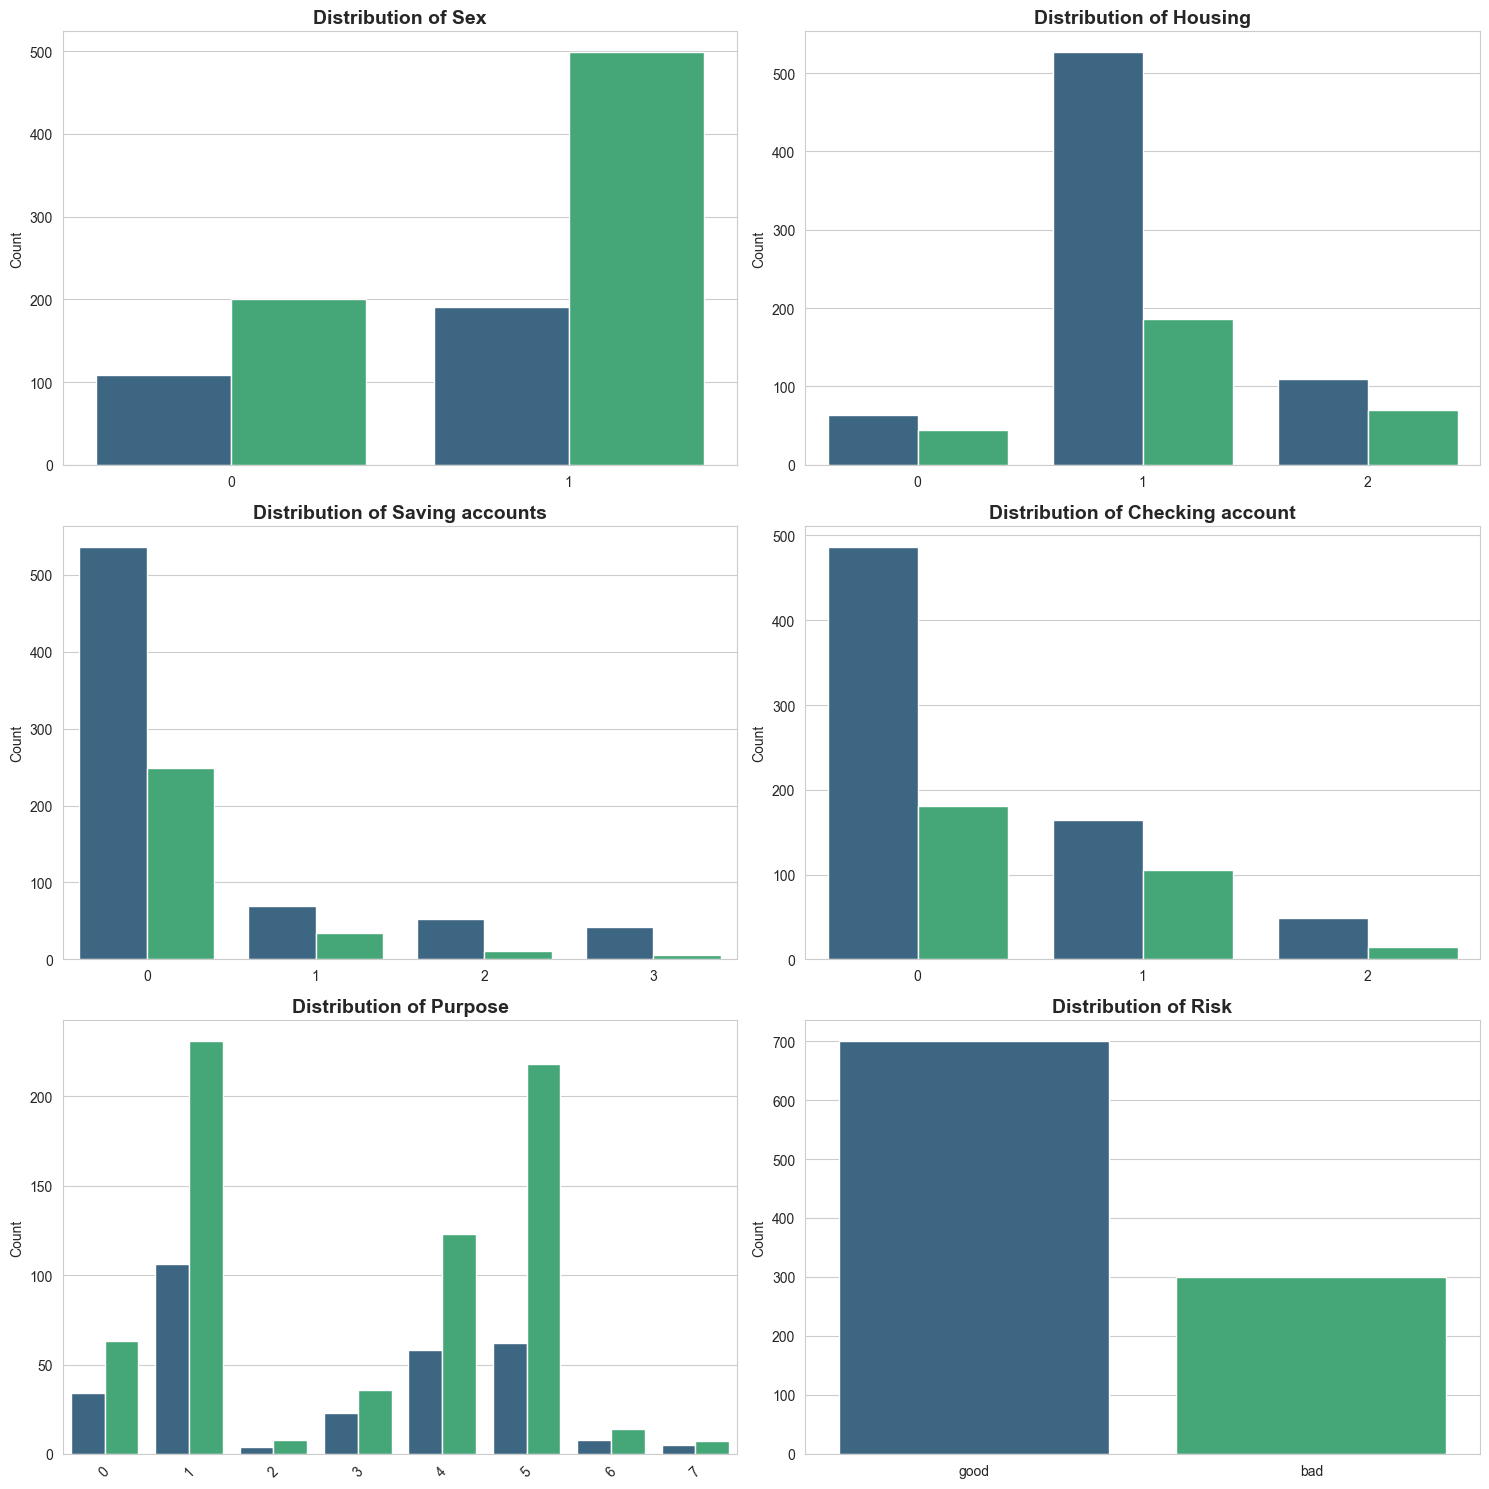

In [30]:
# Define the categorical columns to visualize
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

# Calculate the number of rows needed (2 columns per row)
n_rows = (len(cat_cols) + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
axes = axes.flatten() # Flatten to 1D array for easy looping

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', hue='Risk', legend=False)
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    
    # Rotate labels for "Purpose" as they are long
    if col == 'Purpose':
        axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of plots is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# The "Bad Risk" Heatmap

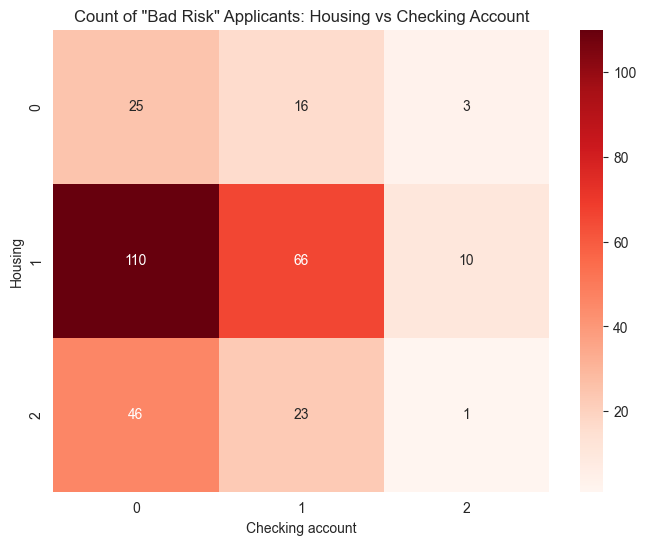

In [29]:
# Pivot table to see average credit amount for Bad Risks only
bad_risk_only = df[df['Risk'] == 'bad']
pivot_table = bad_risk_only.pivot_table(values='Credit amount', 
                                        index='Housing', 
                                        columns='Checking account', 
                                        aggfunc='count')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='Reds')
plt.title('Count of "Bad Risk" Applicants: Housing vs Checking Account')
plt.show()

# SQL query to see the Top 5 most expensive loan purposes for 'Bad' risks

In [32]:
import duckdb

# SQL query to see the Top 5 most expensive loan purposes for 'Bad' risks
query1 = """
SELECT Purpose, COUNT(*) as Total_Applicants, AVG("Credit amount") as Avg_Loan_Size
FROM df
WHERE Risk = 'bad'
GROUP BY Purpose
ORDER BY Avg_Loan_Size DESC
LIMIT 5
"""
duckdb.query(query1).df()

,Purpose,Total_Applicants,Avg_Loan_Size
0,7,5,11566.000000
1,0,34,5622.441176
2,1,106,4221.952830
3,4,58,3645.500000
4,3,23,3151.869565


C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2200533875.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2200533875.py:33: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2200533875.py:33: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2200533875.py:34: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('strategic_insight_1.png')
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2200533875.py:34: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig('strategic_insight_1.png')
c:\Users\chibu

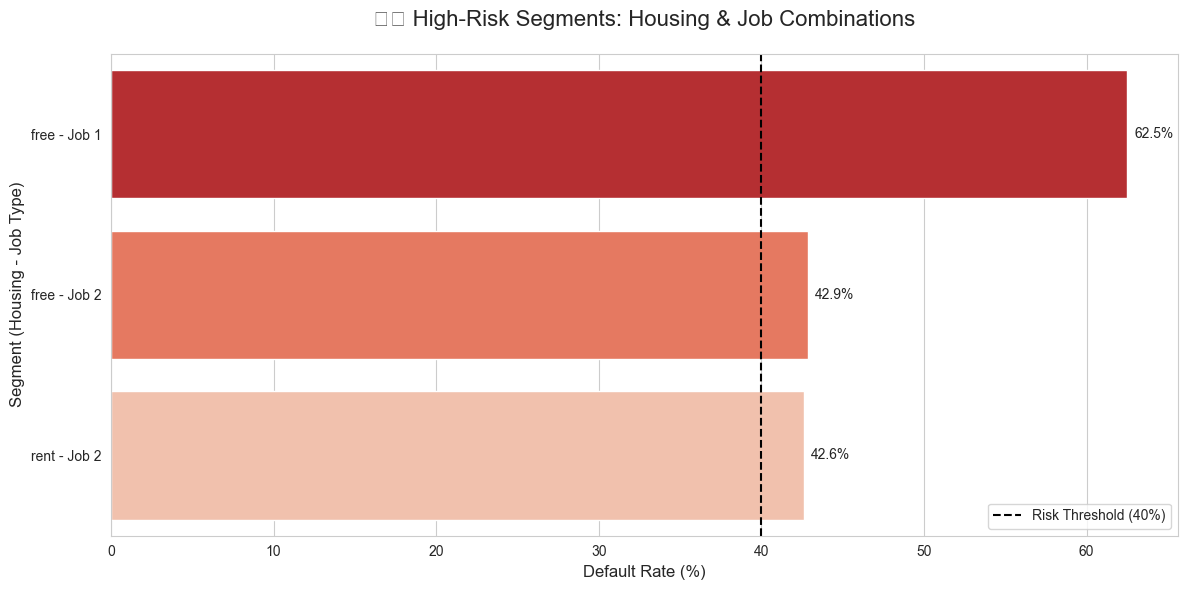

In [43]:
import joblib

# Load the encoders from your models folder
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
encoders = {col: joblib.load(f"models/{col}_encoder.pkl") for col in cat_cols}

# NOW run your plotting code:
high_risk_df['Housing_Label'] = encoders['Housing'].inverse_transform(high_risk_df['Housing'].astype(int))
high_risk_df['Segment'] = high_risk_df['Housing_Label'] + " - Job " + high_risk_df['Job'].astype(str)

# 3. Now run your plot code
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=high_risk_df, 
    x='Default_Rate_Percentage', 
    y='Segment', 
    palette='Reds_r'
)
# ... rest of your plot code ...

# Add a vertical line at 40% to show the "Danger Zone" threshold
plt.axvline(40, color='black', linestyle='--', label='Risk Threshold (40%)')

plt.title('⚠️ High-Risk Segments: Housing & Job Combinations', fontsize=16, pad=20)
plt.xlabel('Default Rate (%)', fontsize=12)
plt.ylabel('Segment (Housing - Job Type)', fontsize=12)
plt.legend()

# Add labels to bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%', padding=5)

plt.tight_layout()
plt.savefig('strategic_insight_1.png')
plt.show()

# 2. Advanced SQL Queries for Business Intelligence

A. High-Risk Segment Identification
This query finds "Danger Zones" by identifying which combinations of Housing and Job status have a default rate higher than 40%

In [33]:
import duckdb

# Note: We use double quotes for columns with spaces and single quotes for strings like 'bad'
query_high_risk = """
SELECT 
    Housing, 
    Job, 
    COUNT(*) AS Total,
    SUM(CASE WHEN Risk = 'bad' THEN 1 ELSE 0 END) AS Bad_Loans,
    ROUND(CAST(SUM(CASE WHEN Risk = 'bad' THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) * 100, 2) AS Default_Rate_Percentage
FROM df
GROUP BY Housing, Job
HAVING Default_Rate_Percentage > 40
ORDER BY Default_Rate_Percentage DESC;
"""

high_risk_df = duckdb.query(query_high_risk).df()
display(high_risk_df)

,Housing,Job,Total,Bad_Loans,Default_Rate_Percentage
0,0,1,8,5.0,62.500000
1,0,2,63,27.0,42.860001
2,2,2,115,49.0,42.610001


In [34]:
query_age_risk = """
SELECT 
    CASE 
        WHEN Age < 25 THEN 'Gen Z / Young Adult'
        WHEN Age BETWEEN 25 AND 40 THEN 'Millennial'
        WHEN Age BETWEEN 41 AND 60 THEN 'Gen X'
        ELSE 'Senior' 
    END AS Age_Group,
    COUNT(*) AS Count,
    AVG("Credit amount") AS Avg_Credit,
    SUM(CASE WHEN Risk = 'bad' THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS Risk_Percent
FROM df
GROUP BY Age_Group
ORDER BY Risk_Percent DESC;
"""

age_risk_df = duckdb.query(query_age_risk).df()
display(age_risk_df)

,Age_Group,Count,Avg_Credit,Risk_Percent
0,Gen Z / Young Adult,149,2958.758389,40.939597
1,Millennial,577,3298.880416,28.942808
2,Gen X,229,3434.305677,27.074236
3,Senior,45,3122.066667,22.222222


In [35]:
query_liquidity = """
SELECT 
    "Saving accounts", 
    "Checking account",
    COUNT(*) as Applicant_Count,
    ROUND(AVG(Duration), 1) as Avg_Months,
    ROUND(AVG("Credit amount"), 2) as Avg_Loan
FROM df
GROUP BY "Saving accounts", "Checking account"
ORDER BY Avg_Loan DESC;
"""

liquidity_df = duckdb.query(query_liquidity).df()
display(liquidity_df)

,Saving accounts,Checking account,Applicant_Count,Avg_Months,Avg_Loan
0,1,1,47,27.7,4212.85
1,0,1,197,22.0,3871.73
2,0,0,538,20.9,3259.54
3,2,1,11,19.5,2798.00
4,1,0,51,19.0,2795.35
5,3,1,14,17.6,2721.57
6,3,0,31,19.0,2678.32
7,2,0,48,19.2,2608.92
8,0,2,51,18.0,2368.10
9,1,2,5,14.0,1597.80


C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2086755064.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2086755064.py:22: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2086755064.py:23: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.savefig('strategic_insight_2.png')
c:\Users\chibuzor\OneDrive\Desktop\python\credit_risk\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


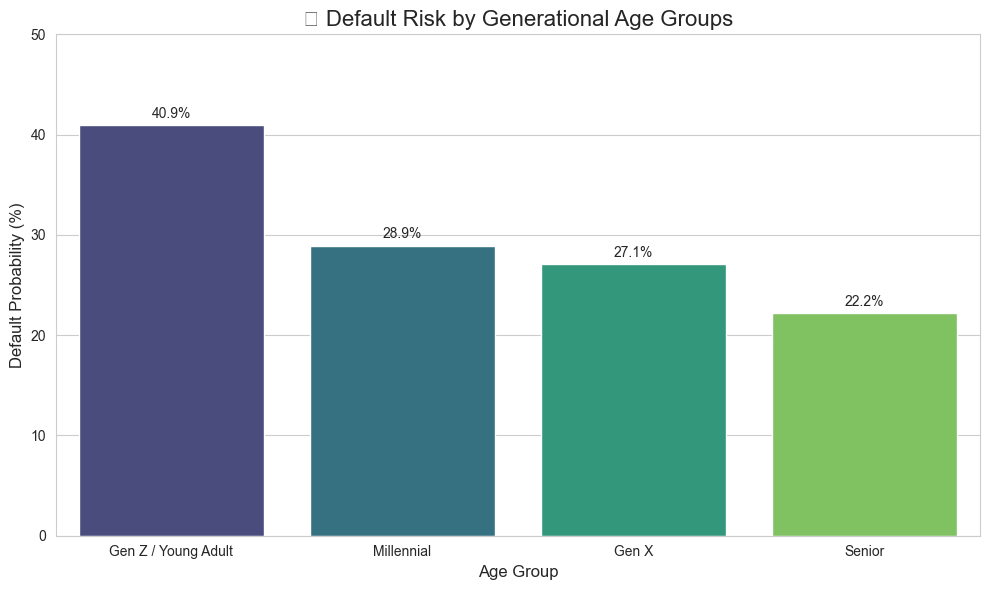

In [39]:
plt.figure(figsize=(10, 6))

# Sort by Risk_Percent for better visualization
age_risk_df = age_risk_df.sort_values('Risk_Percent', ascending=False)

ax = sns.barplot(
    data=age_risk_df, 
    x='Age_Group', 
    y='Risk_Percent', 
    palette='viridis'
)

plt.title('📅 Default Risk by Generational Age Groups', fontsize=16)
plt.ylabel('Default Probability (%)', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.ylim(0, 50) # Set limit to 50% for perspective

# Add labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%', label_type='edge', padding=3)

plt.tight_layout()
plt.savefig('strategic_insight_2.png')
plt.show()

C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2523759420.py:21: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\2523759420.py:22: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.savefig('strategic_insight_3.png')
c:\Users\chibuzor\OneDrive\Desktop\python\credit_risk\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


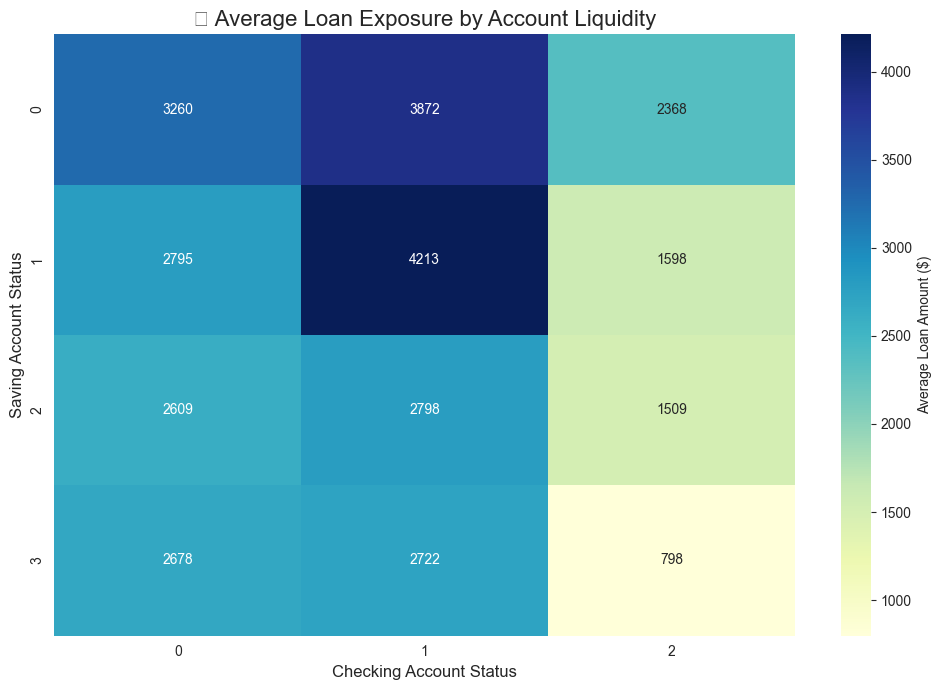

In [40]:
# Pivot the data for the heatmap
heatmap_data = liquidity_df.pivot(
    index="Saving accounts", 
    columns="Checking account", 
    values="Avg_Loan"
)

plt.figure(figsize=(10, 7))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Average Loan Amount ($)'}
)

plt.title('💰 Average Loan Exposure by Account Liquidity', fontsize=16)
plt.xlabel('Checking Account Status', fontsize=12)
plt.ylabel('Saving Account Status', fontsize=12)

plt.tight_layout()
plt.savefig('strategic_insight_3.png')
plt.show()

In [23]:

# Imputing & Encoding Categorical Columns
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in cat_cols:
    # Fill missing values with most frequent
    df[col] = df[col].fillna(df[col].mode()[0])
    # Initialize and Fit
    le = LabelEncoder()
    # We use .astype(str) to ensure we aren't passing numbers to the encoder
    df[col] = le.fit_transform(df[col].astype(str))
    #save to models folder immediate
    joblib.dump(le, f"models/{col}_encoder.pkl")

    print(f"Verified Encoder for {col}. classes learned: {le.classes_}")
# Handling Outliers/Skewness: Log Transformation
df['Credit amount_log'] = np.log(df['Credit amount'])

# Engineering: Monthly Installment Ratio
df['Monthly_Installment'] = df['Credit amount'] / df['Duration']
## Define Features (X) and Target (y)
# Ensure columns match exactly what app.py will send
X = df.drop(["Risk", "Unnamed: 0", "Credit amount"], axis=1, errors='ignore')
y = df["Risk"].map({"good": 1, "bad": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

Verified Encoder for Sex. classes learned: ['female' 'male']
Verified Encoder for Housing. classes learned: ['free' 'own' 'rent']
Verified Encoder for Saving accounts. classes learned: ['little' 'moderate' 'quite rich' 'rich']
Verified Encoder for Checking account. classes learned: ['little' 'moderate' 'rich']
Verified Encoder for Purpose. classes learned: ['business' 'car' 'domestic appliances' 'education' 'furniture/equipment'
 'radio/TV' 'repairs' 'vacation/others']


In [24]:
def train_model(model, params, name):
    grid = GridSearchCV(model, params, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    acc = accuracy_score(y_test, grid.predict(X_test))
    print(f"{name} Best Accuracy: {acc:.4f}")
    return grid.best_estimator_

# Training models
best_dt = train_model(DecisionTreeClassifier(random_state=1), {"max_depth": [3, 5, 7]}, "Decision Tree")
best_rf = train_model(RandomForestClassifier(random_state=1), {"n_estimators": [100, 200]}, "Random Forest")
best_et = train_model(ExtraTreesClassifier(random_state=1), {"n_estimators": [100, 200], "max_depth": [5, 10]}, "Extra Trees")
best_xgb = train_model(XGBClassifier(random_state=1), {"learning_rate": [0.01, 0.1]}, "XGBoost")

# Save the Extra Trees model for your App
joblib.dump(best_et, "models/best_credit_model.pkl")
print("Champion Model (Extra Trees) and Encoders successfully saved to /models/best_credit_model.pkl")

Decision Tree Best Accuracy: 0.6700
Random Forest Best Accuracy: 0.7000
Extra Trees Best Accuracy: 0.7250
XGBoost Best Accuracy: 0.7150
Champion Model (Extra Trees) and Encoders successfully saved to /models/best_credit_model.pkl


C:\Users\chibuzor\AppData\Local\Temp\ipykernel_23680\3846756178.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


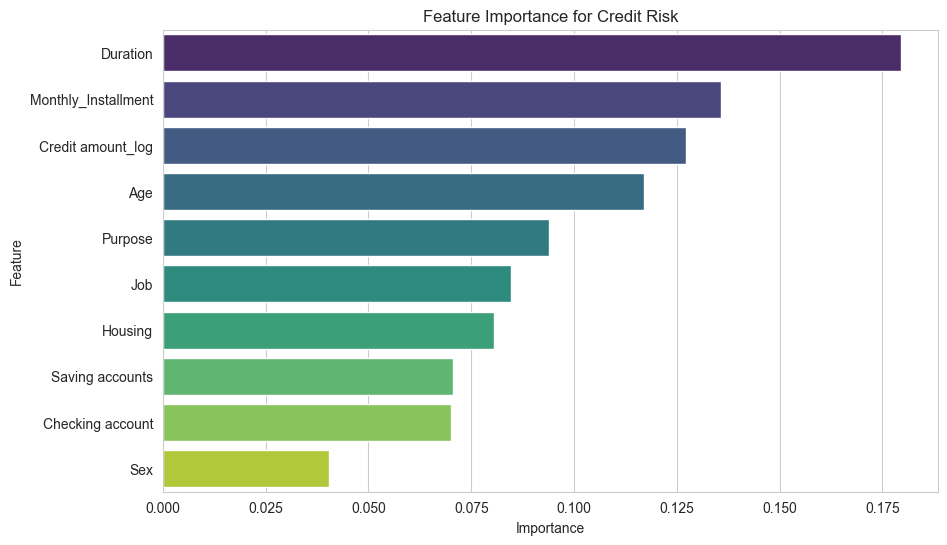

In [31]:
# Get feature importances from the champion model
importances = best_et.feature_importances_
feature_names = X.columns

# Create a DataFrame for the plot
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save this for the app
joblib.dump(feature_importance_df, "models/feature_importance.pkl")

# Visualize it in the notebook
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Credit Risk')
plt.show()

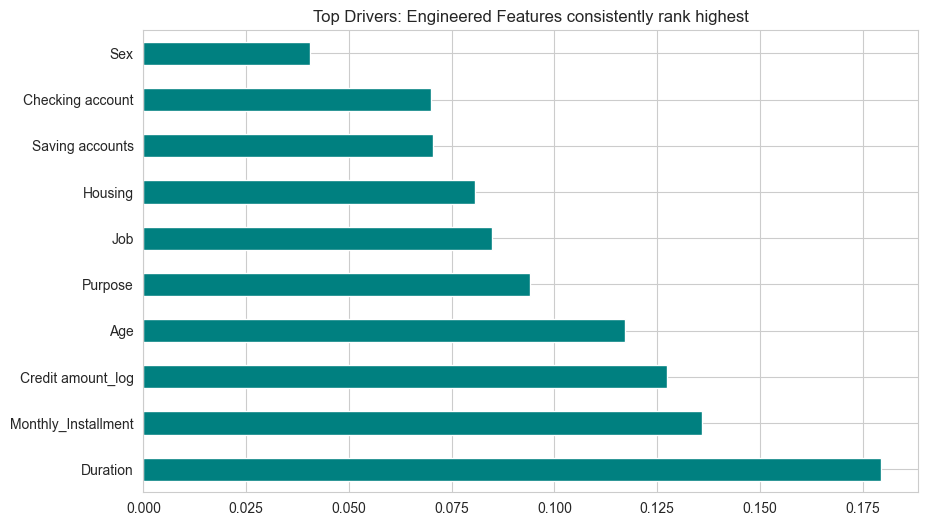

In [44]:
# In your notebook:
# Visualizing that our engineered features (Monthly_Installment, Credit_log) 
# actually show up in the top importance.
importances = best_et.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.plot(kind='barh', color='teal')
plt.title('Top Drivers: Engineered Features consistently rank highest')
plt.show()